In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# factor analysis
import prince
# import mice
# import fancyimpute
# import sklearn
# from statsmodels.graphics.mosaicplot import mosaic\
# import mca # Multiple Correspondence Analysis


# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
# print("Prince Version: " + prince.__version__)
# print("FancyImpute Version: " + fancyimpute.__version__)
# print("Scikit-learn Version:", sklearn.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.2
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.11.9


### Import Data

In [2]:
# data file
df_data = pd.read_pickle("../Data/DF5_cleanDF.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinition.pkl")

# data label
df_label = pd.read_pickle("../Data/colLabel.pkl")

# data label
df_unknown = pd.read_pickle("../Data/colUnknown.pkl")

# remove columns
df_remove = pd.read_pickle("../Data/delColumn.pkl")

# import flat file
df_flat = pd.read_csv("../Data/flatfile.csv")

In [3]:
# checking for duplicated column name
df_data.columns[df_data.columns.duplicated()]

Index([], dtype='object')

#### Data Shape

In [4]:
print(f"Orginal Data file Shape: {df_data.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Remove Column(s) Data rows: {len(df_remove)}")

Orginal Data file Shape: (15282, 335)
Label(s) Data rows: 8
Remove Column(s) Data rows: 116


In [5]:
df_label.head(10)

,truth
0,GraftStatus1
1,GraftLifeSpanDay
2,FollowupNumber
3,TransplantStatus
4,TransplantSurvivalDay
5,GraftStatusType
6,Retyped_DON
7,GraftStatus2


In [6]:
df_unknown.head(10)

,truth
0,StatusDays_1A
1,StatusDays_1B
2,StatusDays_2
3,StatusDays_1
4,StatusDays_A2
5,StatusDays_A3
6,StatusDays_A4
7,StatusDays_A5
8,StatusDays_A6
9,InitialWaitListStatusCode_CAN


### User Function(s):

In [7]:
def corrCols(df, threshold=0.9, method='pearson', flag=False):
    """
    Determine highly corrlated features
    """
    # initilaize variable
    c1 = list()
    c2 = list()
    # calculate the correlation matrix
    correlation_matrix = df.select_dtypes(exclude='object').corr(method=method)
    
    # get the number of features
    num_features = correlation_matrix.shape[0]
    
    # iterate over the upper triangular part of the matrix
    for i in range(num_features):
        for j in range(i+1, num_features):
            feature1 = correlation_matrix.index[i]
            feature2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > threshold:
                c1.append(feature1)
                c2.append(feature2)
                print(f"Correlation between {feature1} and {feature2}: {correlation:.3f}")

    if flag:
        return c1,c2
    else:
        return
    

def percentageNull(df):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (df.count() / len(df) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = df.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn


def DefinitionSearch(datadic, col, flag=False):
    # initialize variable
    parm =  "r'(?i)" + col + "'" # regex search using ignore case sensitivity
    parm = eval(parm)
    # display
    df_str = datadic.loc[:,['featureName','desc', 'dataType', 'labelSAS', 'COMMENT', 'Information']][datadic.featureName.str.contains(parm)]

    if flag:
        feature = datadic.featureName[datadic.featureName.str.contains(parm)].tolist()
        return feature
    else:
        return df_str


def removeColumn(data, col):
    # print initial data file shape
    print(f"Initial Data File Shape: {data.shape}")
    
    # drop column(s)
    data.drop(columns=col, inplace=True)
    
    # print After data file shape
    print(f"After Data File Shape: {data.shape}")

    # deframent DataFrame
    data = data.copy()

    return data


def removeUsingMask(data, removeColLst, colstr='colRemove'):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    return data


def updateDataDict(data, remove, col="COMMENT"):    
    # update data dictionary
    idx = data[data.featureName.isin(remove)].index
    # append to exiting data
    data.loc[idx,col] = "**REMOVED 5** - " + data[col]

    return data


def find_duplicates(lst):
    return list(set([item for item in lst if lst.count(item) > 1]))



def intersectionCol(datadict, cat, string, flag=True):
    # initialize variable
    parm =  "r'(?i)" + string + "'" # regex search using ignore case sensitivity
    parm = eval(parm)
    
    # regex search
    catColD = df_dict.featureName[df_dict.dataType.str.contains(parm)].values
    print("Features from Data Dictionary: ", len(catColD))
    catCol = set(cat).intersection(set(catColD))
    print("Intersection Features: ", len(catCol))

    # display
    missingCol = set(catColD) - set(catCol)
    print("Missing Count", len(missingCol))

    if not flag:
        return list(catCol), list(missingCol)

#### Make Data copy 

In [8]:
# new data file
df = df_data.copy()

# # add df_remove cols
# Colremove = df_remove.colRemove.tolist()

# # display prior len
# print('Initial Length', len(Colremove))

# # use extend for truth label list 
# Colremove.extend(df_label.truth.tolist())

# # display final len
# print('Final Length', len(Colremove))

# # drop unwanted features
# df = removeColumn(df, Colremove)

### Wrangle (Date)

In [9]:
# examine Date columns
DefinitionSearch(df_dict, 'date')

,featureName,desc,dataType,labelSAS,COMMENT,Information
3,AllocationBeginDate,ALLOCATION TIME BEGINNING DATE,NUM,WL LISTING BACK DATE,Unknown,"{'ACTIVATE_DATE': 'AllocationBeginDate', 'ADMISSION_DATE': 'AdmissionDate_CAN', 'ADMIT_DATE_DON': 'AdmissionDate_DON', 'DISCHARGE_DATE': 'CenterDischargeDate', 'END_DATE': 'RemovalWaitListDate', 'INIT_DATE': 'InitialWaitListDate', 'PX_STAT_DATE': 'StatusDate', 'RECOVERY_DATE_DON': 'OrganRecoveryDate_DON', 'REFERRAL_DATE': 'ReferralDate', 'TX_DATE': 'TransplantDate'}"
5,AdmissionDate_CAN,RECIPIENT DATE OF ADMISSION TO TX CENTER,NUM,TRR DATE OF ADMISSION TO TX CENTER,Unknown,"{'ACTIVATE_DATE': 'AllocationBeginDate', 'ADMISSION_DATE': 'AdmissionDate_CAN', 'ADMIT_DATE_DON': 'AdmissionDate_DON', 'DISCHARGE_DATE': 'CenterDischargeDate', 'END_DATE': 'RemovalWaitListDate', 'INIT_DATE': 'InitialWaitListDate', 'PX_STAT_DATE': 'StatusDate', 'RECOVERY_DATE_DON': 'OrganRecoveryDate_DON', 'REFERRAL_DATE': 'ReferralDate', 'TX_DATE': 'TransplantDate'}"
6,AdmissionDate_DON,DONOR ADMIT DATE,NUM,DON ADMIT DATE,Unknown,"{'ACTIVATE_DATE': 'AllocationBeginDate', 'ADMISSION_DATE': 'AdmissionDate_CAN', 'ADMIT_DATE_DON': 'AdmissionDate_DON', 'DISCHARGE_DATE': 'CenterDischargeDate', 'END_DATE': 'RemovalWaitListDate', 'INIT_DATE': 'InitialWaitListDate', 'PX_STAT_DATE': 'StatusDate', 'RECOVERY_DATE_DON': 'OrganRecoveryDate_DON', 'REFERRAL_DATE': 'ReferralDate', 'TX_DATE': 'TransplantDate'}"
71,CenterDischargeDate,RECIPIENT DISCHARGE DATE FROM TX CENTER,NUM,TRR DATE OF DISCHARGE FROM TX CENTER,Unknown,"{'ACTIVATE_DATE': 'AllocationBeginDate', 'ADMISSION_DATE': 'AdmissionDate_CAN', 'ADMIT_DATE_DON': 'AdmissionDate_DON', 'DISCHARGE_DATE': 'CenterDischargeDate', 'END_DATE': 'RemovalWaitListDate', 'INIT_DATE': 'InitialWaitListDate', 'PX_STAT_DATE': 'StatusDate', 'RECOVERY_DATE_DON': 'OrganRecoveryDate_DON', 'REFERRAL_DATE': 'ReferralDate', 'TX_DATE': 'TransplantDate'}"
92,RemovalWaitListDate,"EARLIEST OF DATES OF REMOVAL FROM WAITING LIST, TRANSPLANT, DEATH, OR TIME COPY OF DATA CREATED",NUM,ENDING DATE FOR REGISTRATION,"IF PATIENT TRANSPLANTED OR DIED, BUT WAS REMOVED AFTER THE EVENT, END_DATE IS BACKDATED TO GIVE THE DATE OF EVENT","{'ACTIVATE_DATE': 'AllocationBeginDate', 'ADMISSION_DATE': 'AdmissionDate_CAN', 'ADMIT_DATE_DON': 'AdmissionDate_DON', 'DISCHARGE_DATE': 'CenterDischargeDate', 'END_DATE': 'RemovalWaitListDate', 'INIT_DATE': 'InitialWaitListDate', 'PX_STAT_DATE': 'StatusDate', 'RECOVERY_DATE_DON': 'OrganRecoveryDate_DON', 'REFERRAL_DATE': 'ReferralDate', 'TX_DATE': 'TransplantDate'}"
155,InitialWaitListDate,BEGINNING DATE FOR REGISTRATION,NUM,BEGINNING DATE FOR REGISTRATION,Unknown,"{'ACTIVATE_DATE': 'AllocationBeginDate', 'ADMISSION_DATE': 'AdmissionDate_CAN', 'ADMIT_DATE_DON': 'AdmissionDate_DON', 'DISCHARGE_DATE': 'CenterDischargeDate', 'END_DATE': 'RemovalWaitListDate', 'INIT_DATE': 'InitialWaitListDate', 'PX_STAT_DATE': 'StatusDate', 'RECOVERY_DATE_DON': 'OrganRecoveryDate_DON', 'REFERRAL_DATE': 'ReferralDate', 'TX_DATE': 'TransplantDate'}"
229,StatusDate,RECIPIENT STATUS DATE,NUM,"DATE OF DEATH, RE-TX OR LAST FOLLOW-UP",Unknown,"{'ACTIVATE_DATE': 'AllocationBeginDate', 'ADMISSION_DATE': 'AdmissionDate_CAN', 'ADMIT_DATE_DON': 'AdmissionDate_DON', 'DISCHARGE_DATE': 'CenterDischargeDate', 'END_DATE': 'RemovalWaitListDate', 'INIT_DATE': 'InitialWaitListDate', 'PX_STAT_DATE': 'StatusDate', 'RECOVERY_DATE_DON': 'OrganRecoveryDate_DON', 'REFERRAL_DATE': 'ReferralDate', 'TX_DATE': 'TransplantDate'}"
236,OrganRecoveryDate_DON,ORGAN RECOVERY DATE,NUM,RECOVERY DATE (SENT TO OR),Unknown,"{'ACTIVATE_DATE': 'AllocationBeginDate', 'ADMISSION_DATE': 'AdmissionDate_CAN', 'ADMIT_DATE_DON': 'AdmissionDate_DON', 'DISCHARGE_DATE': 'CenterDischargeDate', 'END_DATE': 'RemovalWaitListDate', 'INIT_DATE': 'InitialWaitListDate', 'PX_STAT_DATE': 'StatusDate', 'RECOVERY_DATE_DON': 'OrganRecoveryDate_DON', 'REFERRAL_DATE': 'ReferralDate', 'TX_DATE': 'TransplantDate'}"
238,ReferralDate,DATE OF REFERRAL CALL,NUM,DDR DATE OF REFERR

In [10]:
# initialize all date variables
columns = DefinitionSearch(df_dict, 'date', True)
# NaN counts
NaNDf = percentageNull(df_data[columns])

# list date NaNs
NaNDf

,percentage,NaNCount
ValidationDate_CAN,27.797409,4248
ValidationDate_DON,27.797409,4248
CenterDischargeDate,4.685251,716
StatusDate,2.787593,426
AdmissionDate_CAN,2.493129,381
ValidationDate_DDR,1.380709,211
AdmissionDate_DON,0.091611,14
ReferralDate,0.091611,14
OrganRecoveryDate_DON,0.085067,13


### Data Engineering (Date)

In [11]:
# create NEW feature
# df_data['WaitListTransplant_difference'] = df_data.TransplantDate - df_data.InitialWaitListDate
df_data['RecoveryTransplant_difference'] = df_data.TransplantDate - df_data.OrganRecoveryDate_DON

# convert to int datatype and use 999 for NaNs
# df_data['WaitListTransplant_difference'] = df_data['WaitListTransplant_difference'].dt.days.fillna(999).astype(int)
df_data['RecoveryTransplant_difference'] = df_data['RecoveryTransplant_difference'].dt.days.fillna(999).astype(int)

In [12]:
# return to original values
# df_data['WaitListTransplant_difference'] = df_data['WaitListTransplant_difference'].mask(df['WaitListTransplant_difference'] == 999, np.nan)
df_data['RecoveryTransplant_difference'] = df_data['RecoveryTransplant_difference'].mask(df_data['RecoveryTransplant_difference'] == 999, np.nan)

In [13]:
# display unique values
# print(df_data['WaitListTransplant_difference'].unique())
print(df_data['RecoveryTransplant_difference'].unique())

[ 0.  1.  4. -1.  2.  3. nan]


In [14]:
# update data dictionary
idx = df_dict[df_dict.featureName.isin(columns)].index
df_dict.loc[idx,'COMMENT'] = "**REMOVED 5** - " + df_dict["COMMENT"]
# remove
df = removeColumn(df_data, columns)

Initial Data File Shape: (15282, 336)
After Data File Shape: (15282, 323)


### Word Cloud Plot

In [15]:
# function to split and clean medications
def split_and_clean(x):
    if pd.isna(x):
        return []
    return [med.strip().upper() for med in str(x).split(',')]


# import library
from wordcloud import WordCloud


def wordFreqPlot(data, txt, flag=True):
    """
    Word Cloud Plot combine multiple Text Features
    """
    # combine the columns
    data['CombinedMeds'] = data[txt].apply(lambda row: 
        list(sum([split_and_clean(cell) for cell in row if pd.notna(cell)], [])), axis=1)
    
    # convert the list to a comma-separated string
    data['CombinedMeds'] = data['CombinedMeds'].apply(lambda x: ', '.join(sorted(x)) if x else None)

    #
    if flag:
        # combine all medications into a single string
        text = ' '.join(df['CombinedMeds'].dropna().astype(str))
        
        # preprocess text: Convert to upper case and remove duplicates
        text = ' '.join(set(word.upper() for word in text.split(',')))
    
        # Create and generate a word cloud image
        wordcloud = WordCloud(width=1200, height=800, background_color='white').generate(text)
        
        # display the generated image
        plt.figure(figsize=(16, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Combine {len(txt)} Text Columns **{txt}** Word Cloud \n", fontsize=15)
        plt.tight_layout(pad=0)
        plt.show()
    else:
        return  data['CombinedMeds']

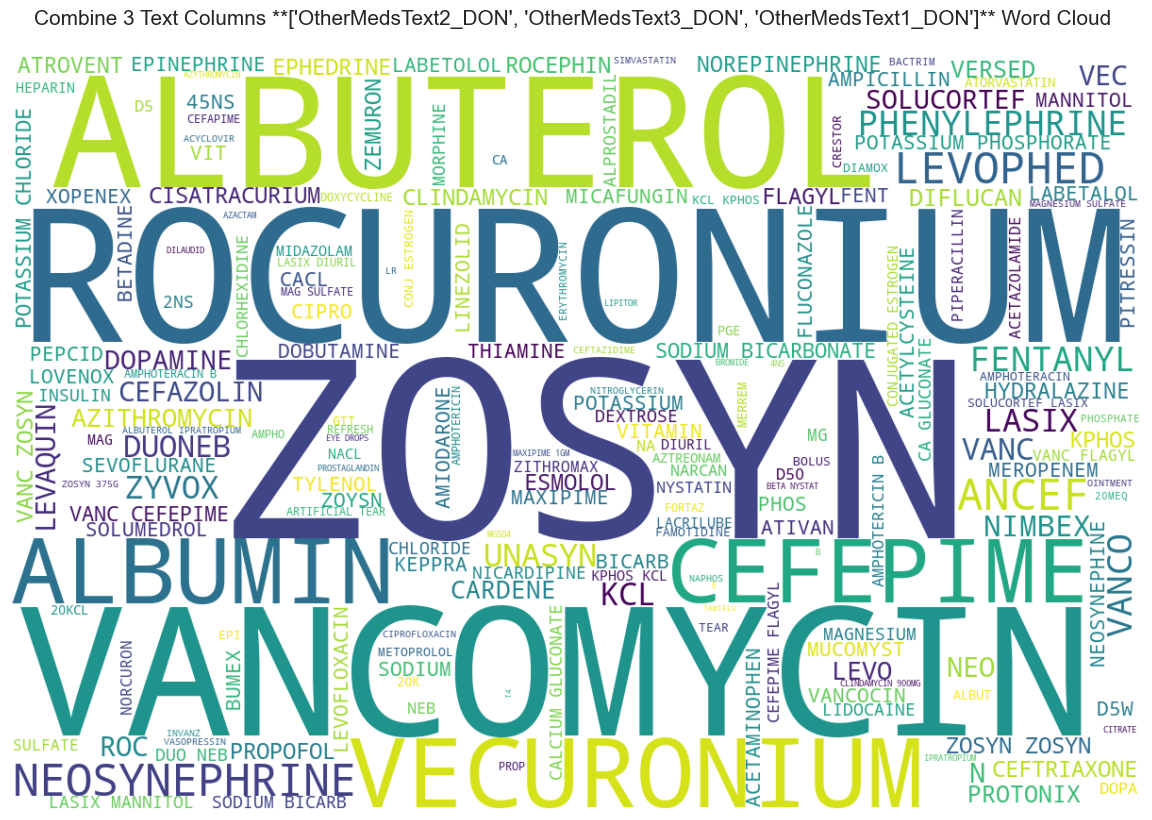

In [16]:
# initialize list
txtlst = ['OtherMedsText2_DON', 'OtherMedsText3_DON', 'OtherMedsText1_DON']
# plot
wordFreqPlot(df, txtlst, flag=True)

**Note:**
- **ZOSYN** (piperacillin and tazobactam for injection, USP) is an injectable antibacterial combination product consisting of the semisynthetic antibiotic piperacillin sodium and the β‑lactamase inhibitor tazobactam sodium for intravenous administration. Piperacillin sodium is derived from D(-)-α-aminobenzyl-penicillin.
- **Rocuronium** is a non-depolarizing neuromuscular blocker widely used to produce muscle relaxation to help facilitate surgery and ventilation of the lungs in elective and emergent situations.
- **Vancomycin** is a tricyclic glycopeptide antibiotic originally derived from the organism Streptococcus orientalis. Vancomycin is used to treat and prevent various bacterial infections caused by gram-positive bacteria, including methicillin-resistant Staphylococcus aureus (MRSA).
- **Vecuronium** is a nondepolarizing agent that achieves skeletal muscle paralysis by competing with acetylcholine for cholinergic receptor sites and binding with the nicotinic cholinergic receptor at the postjunctional membrane of the motor endplate.
- **Albuterol** is used to prevent and treat difficulty breathing, wheezing, shortness of breath, coughing, and chest tightness caused by lung diseases such as asthma and chronic obstructive pulmonary disease (COPD; a group of diseases that affect the lungs and airways).

In [17]:
# add new text feature to be removed
removeCol = txtlst

# remove text features/
df = removeColumn(df, removeCol)

Initial Data File Shape: (15282, 324)
After Data File Shape: (15282, 321)


#### User Function(s)

In [18]:
def catNumeric(data, catCols):
    # initialized variable
    numericValues =[]
    nonNumericValues =[]
    # check categorical columns for numeric values
    for col in catCols:
        series = pd.Series(data[col].astype(str))
        # convert to numeric, coercing errors to NaN to determine numerical category variable
        if pd.to_numeric(series, errors='coerce').notna().all():
            numericValues.append(col)
        else:
            nonNumericValues.append(col)
    
    # return
    return numericValues, nonNumericValues


def addtionalInfo(data, lst):
    # iterate
    for val in lst:
        # mode (first if multiple)
        modeValue = data[val].mode()[0]
        modePercentage = data[val].value_counts(normalize=True,dropna=False)[modeValue]
        modeCount = data[val].value_counts()[modeValue]
        unique = data[val].nunique(dropna=False)

        # display
        print(f"**{val}** Unique: {unique} & Mode: {modeValue} & Total Count: {modeCount:,} & Percentage: {(modePercentage * 100):.2f}%")


import scipy.stats as stats

def correlation(data, col1, col2):
    """
    Spearman's rank correlation is a non-parametric measure of the monotonicity of the relationship between two variables.
    """
    data = data.dropna()
    correlation, p_value = stats.spearmanr(data[col1], data[col2])
    r, p = stats.pearsonr(data[col1], data[col2])

    print(f"Spearman correlation: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}\n")
    print(f"Pearson correlation coefficient: {r:.4f}")
    print(f"P-value: {p:.4f}")


def plotCount(data, cols, width=16, height=10, angle=False):
    # figure size
    plt.figure(figsize=(width, height))
    
    # assuming cols is your list of categorical columns
    for i, col in enumerate(cols, start=1):
        plt.subplot(3, 4, i)
        sns.countplot(data=data, x=col)
        plt.title(f'Countplot of {col}')
        plt.xlabel(col)
        if angle:
            plt.xticks(rotation=90) 
    
    plt.tight_layout()  # Adjust the layout
    plt.show()



### Examine NaN columns

In [19]:
# NaN counts
NaNDf = percentageNull(df)

# remove feature(s) with over 40% NaNs
removeCol = NaNDf[NaNDf.percentage >= 40].index.values

# dispaly
NaNDf[NaNDf.percentage >= 40]

,percentage,NaNCount
TotalSerumAlbumin_CAN,97.853684,14954
PriorCardiacSurgeryTextType_CAN,79.773590,12191
InotropicAgent_DON,65.181259,9961


#### Remove Features

##### User Function

In [20]:
def houseKeeping(data, dataDict, dataRemove, dataUnknown, removeCol):
    # update data dictionary (house keeping)
    dataDict = updateDataDict(dataDict, removeCol)
    
    # remove df_remove DataFrame data (house keeping)
    dataRemove = removeUsingMask(dataRemove, removeCol)
    dataUnknown = removeUsingMask(dataUnknown, removeCol, colstr='truth')
    
    # remove text features
    data = removeColumn(data, removeCol)

    return data, dataDict, dataRemove, dataUnknown

In [21]:
# helper functions for house keeping
df, df_dict, df_remove, df_unknown = houseKeeping(df, df_dict, df_remove, df_unknown, removeCol)

Initial Data File Shape: (15282, 321)
After Data File Shape: (15282, 318)


In [22]:
# # initialize variable
# removeCol = df_label.truth[df_label.truth != 'TransplantSurvivalDay'].values

# # update data dictionary (house keeping)
# df_dict = updateDataDict(df_dict, removeCol)

# # remove df_remove DataFrame data (house keeping)
# df_remove = removeUsingMask(df_remove, removeCol)

# # remove unwanted label features
# df = removeColumn(df, removeCol)

### Examine Unknown Features

In [23]:
# display shape
print(df_unknown.shape)

# initialize array
unknownCol = list(df_unknown.truth.values)

#
df[unknownCol].head()

(26, 1)


,StatusDays_1A,StatusDays_1B,StatusDays_2,StatusDays_1,StatusDays_A2,StatusDays_A3,StatusDays_A4,StatusDays_A5,StatusDays_A6,InitialWaitListStatusCode_CAN,EndWaitListStatusCode_CAN,TransplantRegion,AntigenHistocompatibility_A1_DON,AntigenHistocompatibility_A2_DON,AntigenHistocompatibility_B1_DON,AntigenHistocompatibility_B2_DON,AntigenHistocompatibility_DR1_DON,AntigenHistocompatibility_DR2_DON,AntigenHLAcompatibility_B1,AntigenHLAcompatibility_B2,AntigenHLAcompatibility_DR1,AntigenHLAcompatibility_DR2,MismatchLevel_LOCUS,MismatchLevel_HLA,MismatchLevel_B_LOCUS,MismatchLevel_DR_LOCUS
0,118,126,0,0,0,0,0,0,0,HR: Status 1B,2010,1,2.0,32.0,61.0,98.0,4.0,13.0,NaN,NaN,NaN,NaN,999,999,999,999
1,68,0,0,0,0,0,0,0,0,HR: Status 1A,2010,11,1.0,68.0,39.0,60.0,4.0,11.0,NaN,NaN,NaN,NaN,999,999,999,999
2,0,19,0,0,0,0,0,0,0,HR: Status 1B,2020,5,2.0,11.0,44.0,55.0,4.0,13.0,56.0,57.0,1.0,17.0,2,6,2,2
3,31,367,0,0,0,0,0,0,0,HR: Status 1B,2010,8,1.0,23.0,8.0,49.0,17.0,11.0,8.0,44.0,4.0,11.0,2,4,1,1
4,9,281,0,0,0,0,0,0,0,HR: Status 1B,2010,10,3.0,25.0,7.0,60.0,13.0,15.0,7.0,35.0,4.0,15.0,1,3,1,1


In [24]:
# initialize list
removeCol = ['InitialWaitListStatusCode_CAN', 'EndWaitListStatusCode_CAN', 'TransplantRegion']
# helper functions for house keeping
df, df_dict, df_remove, df_unknown = houseKeeping(df, df_dict, df_remove, df_unknown, removeCol)

Initial Data File Shape: (15282, 318)
After Data File Shape: (15282, 315)


#### Determine DataFrame Datatypes 

##### User Function

In [25]:
def datatypeDF(data, display=True):
    # initialize variables for all the column name per each datatype
    boolCol = data.select_dtypes(include=['bool']).columns.tolist()
    catCol = data.select_dtypes(include=['category']).columns.tolist()
    objCol = data.select_dtypes(include=['object']).columns.tolist()
    numCol = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if display:
        # display feature counts
        print('Total Data feature count: ', df.shape[1])
        print(f"\nBoolean feature count: {len(boolCol)}")
        print(f"Category feature count: {len(catCol)}")
        print(f"Numeric feature count: {len(numCol)}")
        print(f"Object feature count: {len(objCol)}\n")
        print('Total feature count: ' ,len(boolCol) + len(catCol) + len(objCol) + len(numCol))
    else:
        return boolCol, catCol, objCol, numCol

In [26]:
# initialize array
unknownCol = list(df_unknown.truth.values)
# display
datatypeDF(df[unknownCol], True)
# initialize list
boolCol, catCol, objCol, numCol = datatypeDF(df[unknownCol], False)

Total Data feature count:  315

Boolean feature count: 0
Category feature count: 4
Numeric feature count: 19
Object feature count: 0

Total feature count:  23


In [27]:
# correlation matrix
df[numCol].corr(method='pearson')

,StatusDays_1A,StatusDays_1B,StatusDays_2,StatusDays_1,StatusDays_A2,StatusDays_A3,StatusDays_A4,StatusDays_A5,StatusDays_A6,AntigenHistocompatibility_A1_DON,AntigenHistocompatibility_A2_DON,AntigenHistocompatibility_B1_DON,AntigenHistocompatibility_B2_DON,AntigenHistocompatibility_DR1_DON,AntigenHistocompatibility_DR2_DON,AntigenHLAcompatibility_B1,AntigenHLAcompatibility_B2,AntigenHLAcompatibility_DR1,AntigenHLAcompatibility_DR2
StatusDays_1A,1.000000,0.289700,0.023648,-0.033909,-0.042456,0.017670,-0.056669,-0.022591,-0.056236,-0.011760,-0.008543,-0.024384,-0.026323,-0.013287,-0.018238,-0.047056,-0.044982,-0.023472,-0.049874
StatusDays_1B,0.289700,1.000000,0.041556,-0.036141,-0.049103,0.076692,0.139747,-0.022177,-0.046141,-0.013472,-0.017238,-0.020306,-0.028272,-0.007877,-0.018084,-0.037686,-0.046140,-0.032949,-0.054979
StatusDays_2,0.023648,0.041556,1.000000,-0.020528,-0.025334,0.001992,0.049268,0.064573,0.164784,-0.002653,-0.009934,-0.012704,-0.000760,-0.005794,-0.007300,-0.032563,-0.035187,-0.018483,-0.023520
StatusDays_1,-0.033909,-0.036141,-0.020528,1.000000,0.034164,-0.003477,-0.012353,-0.006734,-0.008411,0.002317,0.002684,0.000248,0.005748,0.008043,0.000814,-0.011403,-0.006348,0.003176,-0.007207
StatusDays_A2,-0.042456,-0.049103,-0.025334,0.034164,1.000000,0.071797,0.026606,0.006910,0.034725,0.007875,0.021391,0.025900,0.019626,0.035728,0.012138,-0.009991,-0.015302,-0.005949,-0.016509
StatusDays_A3,0.017670,0.076692,0.001992,-0.003477,0.071797,1.000000,0.158473,-0.007138,-0.015021,0.005399,0.015620,0.006660,0.011246,0.010522,0.005536,-0.000742,-0.009096,-0.005747,-0.012262
StatusDays_A4,-0.056669,0.139747,0.049268,-0.012353,0.026606,0.158473,1.000000,-0.014133,-0.002858,0.014928,0.016503,0.009786,0.025083,0.032015,0.027374,-0.010305,-0.003736,-0.004908,-0.011883
StatusDays_A5,-0.022591,-0.022177,0.064573,-0.006734,0.006910,-0.007138,-0.014133,1.000000,-0.008109,-0.003685,-0.003381,-0.005948,-0.001344,0.002493,-0.007005,-0.004645,-0.005859,0.000508,-0.009570
StatusDays_A6,-0.056236,-0.046141,0.164784,-0.008411,0.034725,-0.015021,-0.002858,-0.008109,1.000000,-0.000558,0.018197,0.006428,0.015891,-0.001233,0.008793,0.017253,0.010618,0.012836,0.002058
AntigenHistocompatibility_A1_DON,-0.011760,-0.013472,-0.002653,0.002317,0.007875,0.005399,0.014928,-0.003685,-0.000558,1.000000,0.293031,0.243023,0.262186,0.054511,0.251951,0.048242,0.032622,0.018346,0.041483


#### Test of Independence for Categorical Variables
- Null Hypothesis (H0): The two variables are not related.
- Alternative Hypothesis (H1): The two variables are related.
- A low p-value (typically < 0.05) indicates a significant relationship between the variables.
- This is the Chi-Square test statistic. It measures the discrepancy between the observed and expected frequencies under the assumption that the variables are independent.
    - A larger `chi2` value indicates a greater difference between observed and expected counts, suggesting that the variables are more likely to be associated.
    - A small p_value (typically < 0.05) suggests that you can reject the null hypothesis and conclude that there is a significant association between the two variables.

#### Cramer's V values can be interpreted as:
- Cramer's V is a measure of association between two nominal (categorical) variables, based on the Chi-Square statistic and varies from `0` (corresponding to no association between the variables) to `1` (complete association) and can reach 1 only when each variable is completely determined by the other.
    - 0.00 to 0.10: Negligible association
    - 0.10 to 0.30: Weak association
    - 0.30 to 0.50: Moderate association
    - 0.50 to 0.70: Strong association
    - 0.70 to 1.00: Very strong association

#### User Function(s)

In [28]:
# import library
from scipy.stats import chi2_contingency
from itertools import combinations


def pairColsMultiIndependenceCat(data, catCol):
    """
    Hypothesis testing using Chi-square statistic and calculating Cramer's V to 
    build consensus for all the categorical variables. 
    """
    # initialize variables
    results = []
    validCols = [col for col in catCol if col in data.columns]

    # use combinations to get unique pairs of columns
    for col1, col2 in combinations(validCols, 2):
        # create a contingency table
        contingencyTable = pd.crosstab(data[col1], data[col2])
        chi2, p_value, _, _ = chi2_contingency(contingencyTable)
        # total number of observations
        n = contingencyTable.values.sum()
        # get the number of categories in each variable (rows and columns)
        r, k = contingencyTable.shape
        min_dim = min(r-1, k-1)
        
        # handle division by zero
        if n * min_dim == 0:
            cramer_v = np.nan
        else:
            cramer_v = np.sqrt(chi2 / (n * min_dim))
        
        results.append({
            'column1': col1,
            'column2': col2,
            'chi2': chi2,
            'p_value': p_value,
            'cramer_v': cramer_v
        })
    
    return pd.DataFrame(results).sort_values(by='cramer_v', ascending=False)
    
    
    
def testIndependenceCat(data, cat1, cat2, flag=False):
    """
    Hypothesis testing using Chi-square statistic and calculating Cramer's V to 
    build consensus for two categorical variables.
    """
    # create a contingency table
    contingencyTable = pd.crosstab(data[cat1], data[cat2])
    # perform Chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingencyTable)
    
    # total number of observations
    n = contingencyTable.sum().sum()
    # get the number of categories in each variable (rows and columns)
    r, k = contingencyTable.shape
    # calculate Cramer's V
    cramer_v = np.sqrt(chi2 / (n * min(k-1, r-1)))

    # display
    print(f"Test of Independence for Catergorical Variables: {cat1} & {cat2}")
    print(f"Chi-square statistic: {chi2:,.2f}")
    print(f"p-value: {p_value:,.4f}")
    print(f"Cramer's V: {cramer_v:,.4f}")

    if flag:
        return contingencyTable


In [29]:
# stats test
pairColsMultiIndependenceCat(df[catCol], catCol)

,column1,column2,chi2,p_value,cramer_v
0,MismatchLevel_LOCUS,MismatchLevel_HLA,23313.368865,0.0,0.713102
4,MismatchLevel_HLA,MismatchLevel_DR_LOCUS,23056.350323,0.0,0.709161
3,MismatchLevel_HLA,MismatchLevel_B_LOCUS,22594.228809,0.0,0.702018
5,MismatchLevel_B_LOCUS,MismatchLevel_DR_LOCUS,15498.716682,0.0,0.581430
1,MismatchLevel_LOCUS,MismatchLevel_B_LOCUS,15409.696265,0.0,0.579757
2,MismatchLevel_LOCUS,MismatchLevel_DR_LOCUS,15267.830908,0.0,0.577083


In [30]:
print({df.MismatchLevel_LOCUS.dtypes})
print({df.MismatchLevel_HLA.dtypes})
print({df.MismatchLevel_B_LOCUS.dtypes})
print({df.MismatchLevel_DR_LOCUS.dtypes})

{CategoricalDtype(categories=[0, 1, 2, 999], ordered=False, categories_dtype=Int64)}
{CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 999], ordered=False, categories_dtype=Int64)}
{CategoricalDtype(categories=[0, 1, 2, 999], ordered=False, categories_dtype=Int64)}
{CategoricalDtype(categories=[0, 1, 2, 999], ordered=False, categories_dtype=Int64)}


In [31]:
# correlation matrix
df[catCol].corr(method='pearson')

,MismatchLevel_LOCUS,MismatchLevel_HLA,MismatchLevel_B_LOCUS,MismatchLevel_DR_LOCUS
MismatchLevel_LOCUS,1.000000,0.998765,0.999586,0.998354
MismatchLevel_HLA,0.998765,1.000000,0.998356,0.999587
MismatchLevel_B_LOCUS,0.999586,0.998356,1.000000,0.998766
MismatchLevel_DR_LOCUS,0.998354,0.999587,0.998766,1.000000


In [32]:
# correlation matrix
df[catCol].corr(method='spearman')

,MismatchLevel_LOCUS,MismatchLevel_HLA,MismatchLevel_B_LOCUS,MismatchLevel_DR_LOCUS
MismatchLevel_LOCUS,1.000000,0.738798,0.375009,0.316899
MismatchLevel_HLA,0.738798,1.000000,0.681880,0.726104
MismatchLevel_B_LOCUS,0.375009,0.681880,1.000000,0.386414
MismatchLevel_DR_LOCUS,0.316899,0.726104,0.386414,1.000000


In [38]:
df[['MismatchLevel_B_LOCUS', 'MismatchLevel_LOCUS']].corr(method='spearman')

,MismatchLevel_B_LOCUS,MismatchLevel_LOCUS
MismatchLevel_B_LOCUS,1.000000,0.375009
MismatchLevel_LOCUS,0.375009,1.000000


In [33]:
contingencyTable = testIndependenceCat(df, 'MismatchLevel_B_LOCUS', 'MismatchLevel_LOCUS', True)

Test of Independence for Catergorical Variables: MismatchLevel_B_LOCUS & MismatchLevel_LOCUS
Chi-square statistic: 15,409.70
p-value: 0.0000
Cramer's V: 0.5798


In [34]:
contingencyTable

MismatchLevel_LOCUS,0,1,2,999
MismatchLevel_B_LOCUS,,,,
0,36,121,120,0
1,289,1690,1601,0
2,559,4056,5476,1
999,0,0,0,1333


In [35]:
import prince

In [1]:
# order categories
catOrdered = ["999", "1", "2", "3", "4", "5", "6"]
df['MismatchLevel_B_LOCUS'] = pd.Categorical(df['MismatchLevel_B_LOCUS'], categories=catOrdered)
df['MismatchLevel_LOCUS'] = pd.Categorical(df['MismatchLevel_LOCUS'], categories=catOrdered)

# preform Correspondence Analysis
ca = prince.CA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
ca = ca.fit(df[['MismatchLevel_B_LOCUS', 'MismatchLevel_LOCUS']])

NameError: name 'pd' is not defined

In [51]:


print("prince version: ", prince.__version__)


# Perform MCA
mca = prince.MCA(n_components=2, random_state=42)
mca = mca.fit(df[['MismatchLevel_B_LOCUS', 'MismatchLevel_LOCUS']])



prince version:  0.13.0


- In MCA, "mass" represents the relative frequency or weight of each categorical level.
It indicates how much each level contributes to the overall structure of the data.
- The values reflect the proportion of observations for each mismatch level relative to the total number of observations in your dataset.
    - MismatchLevel_B_LOCUS_2 has the highest mass at 0.330192, indicating it is the most prevalent category among the mismatch levels in your dataset.
    - MismatchLevel_B_LOCUS_1 follows with a mass of 0.117131, while MismatchLevel_B_LOCUS_0 has a very low mass of 0.009063, indicating very few observations for that level.
    - MismatchLevel_LOCUS categories, MismatchLevel_LOCUS_2 has a significant mass of 0.235473, while MismatchLevel_LOCUS_999 has a much lower mass of 0.043646.
- The mca.col_masses_ values provide crucial insight into the distribution of the mismatch levels within your dataset. Understanding these masses can help you interpret the results of your MCA, identify which categories are most influential, and guide further analysis or visualization efforts

In [39]:
mca.col_masses_

MismatchLevel_B_LOCUS_0      0.009063
MismatchLevel_B_LOCUS_1      0.117131
MismatchLevel_B_LOCUS_2      0.330192
MismatchLevel_B_LOCUS_999    0.043613
MismatchLevel_LOCUS_0        0.028923
MismatchLevel_LOCUS_1        0.191958
MismatchLevel_LOCUS_2        0.235473
MismatchLevel_LOCUS_999      0.043646
dtype: float64

- Values in Component 0 represent the contribution of each category to the first principal component, while values in Component 1 represent the contribution to the second principal component.
- MismatchLevel_B_LOCUS_999 has a very high contribution of 0.456387 to Component 0, suggesting it significantly influences this component. In contrast, its contribution to Component 1 is extremely low (0.00000001).
- MismatchLevel_B_LOCUS_1 shows a substantial contribution to Component 1 (0.29680070) but a much lower contribution to Component 0 (0.011212).
- Categories that have high contributions to one or both components are more influential in defining the relationships captured by those dimensions.
    - The high contributions of MismatchLevel_B_LOCUS_999 and MismatchLevel_LOCUS_999 to Component 0 suggest they play a crucial role in the variance explained by that component, while others contribute to Component 1.
- The mca.column_contributions_ values provide valuable insights into how each category contributes to the principal components generated by your MCA. This information is essential for interpreting the results, understanding the relationships within your data, and guiding further analysis or visualization efforts.

In [41]:
mca.column_contributions_

,0,1
MismatchLevel_B_LOCUS_0,0.000868,6.798656e-02
MismatchLevel_B_LOCUS_1,0.011212,2.968007e-01
MismatchLevel_B_LOCUS_2,0.031534,1.352127e-01
MismatchLevel_B_LOCUS_999,0.456387,1.022603e-08
MismatchLevel_LOCUS_0,0.002767,1.739888e-01
MismatchLevel_LOCUS_1,0.018360,1.178920e-01
MismatchLevel_LOCUS_2,0.022519,2.081192e-01
MismatchLevel_LOCUS_999,0.456354,8.788449e-11


In [47]:
mca.

<bound method CA._column_cosine_similarities of MCA(random_state=42)>

In [46]:
dir(mca)

['J_',
 'K_',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_column_cosine_similarities',
 '_eigenvalues_summary',
 '_get_default_requests',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_prepare',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_row_cosine_similarities',
 '_sklearn_auto_wrap_output_keys',
 '_validate_data',
 '_validate_params',
 'active_cols_',
 'active_rows_',
 'check_input',
 'col_masses_',
 'column_contributions_',
 'column_coordinates',
 'column_cosine_similarities',

In [1]:
# # convert boolean columns to category
# cols = df_encoded.select_dtypes(include='bool').columns.to_list()
# df_encoded[cols] = df_encoded[cols].astype('category')

# convert Categories to Numerical Format:
# df_encoded[cols] = df_encoded[cols].apply(lambda x: x.cat.codes)

# # Step 4: Get the transformed data
# reduced_data = famd.transform(df[categorical_cols + numerical_cols])

# Optional: Visualize the first two components
# famd.plot_row_coordinates(df[categorical_cols + numerical_cols], ax=None, figsize=(10, 10), show_points=True)

# # Visualize the first two components
# # famd.plot_row_coordinates(df_encoded, ax=None, figsize=(10, 10), show_points=True)

In [2]:
# from sklearn.metrics.pairwise import cosine_similarity
# # get the column contributions (factor loadings)
# column_contributions = famd_3.column_contributions_

# # calculate the cosine similarity between original features and components
# cosine_similarities = cosine_similarity(column_contributions)

# np.set_printoptions(precision=2)
# cosine_similarities[:2]

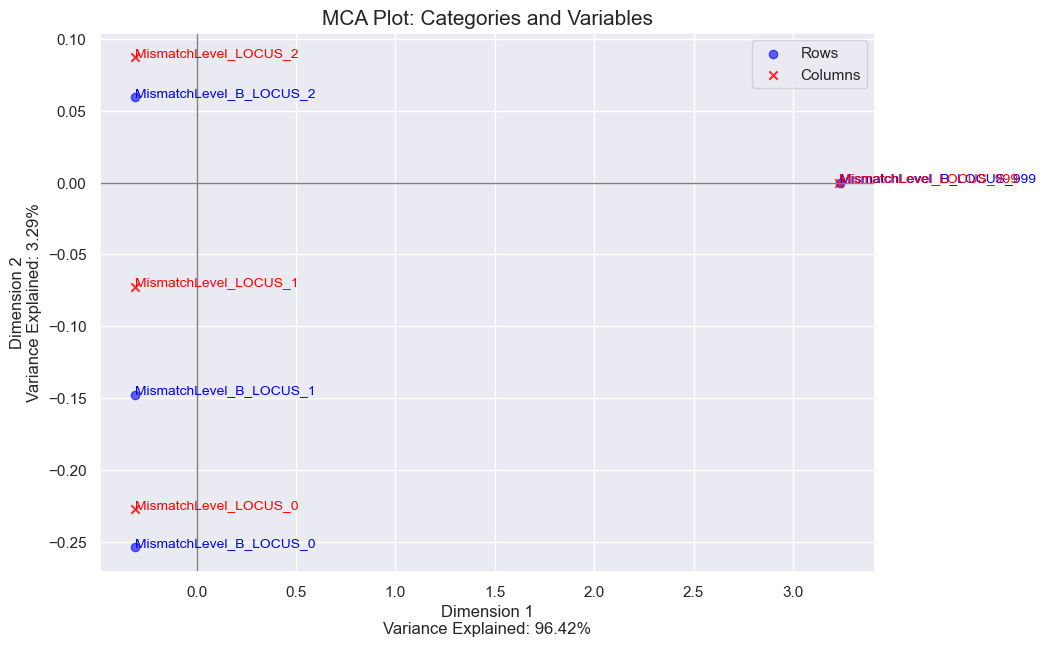

<Figure size 640x480 with 0 Axes>

In [47]:
# Assuming `contingencyTable` is defined as your input data.
# Also assuming you have a list of column names (categories) corresponding to your contingency table.
column_names = ["MismatchLevel_LOCUS_0", "MismatchLevel_LOCUS_1", "MismatchLevel_LOCUS_2", "MismatchLevel_LOCUS_999"]  # Replace with actual category names if different
row_names = ["MismatchLevel_B_LOCUS_0", "MismatchLevel_B_LOCUS_1", "MismatchLevel_B_LOCUS_2", "MismatchLevel_B_LOCUS_999"]  # Replace with actual category names if different

# Perform MCA
mca_b = mca.MCA(contingencyTable, benzecri=False)

# Get row and column coordinates for the first 2 dimensions
row_coords = mca_b.fs_r(N=2)  # Row factor scores (dim 1 and dim 2)
col_coords = mca_b.fs_c(N=2)  # Column factor scores (dim 1 and dim 2)

# Calculate the SVD directly from the contingency table
U, S, Vt = np.linalg.svd(contingencyTable, full_matrices=False)

# Calculate eigenvalues from singular values
eigenvalues = S**2 / (contingencyTable.sum(axis=0).size - 1)  # Adjust based on your data size
total_inertia = sum(eigenvalues)
variance_explained = [val / total_inertia for val in eigenvalues]

# Plot
plt.figure(figsize=(10, 7))

# Plot rows (categories)
plt.scatter(row_coords[:, 0], row_coords[:, 1], color='blue', label='Rows', alpha=0.6)

# Plot columns (variables)
plt.scatter(col_coords[:, 0], col_coords[:, 1], color='red', marker='x', label='Columns', alpha=0.8)

# Annotate points for rows with category names only
for i, row in enumerate(row_coords):
    plt.text(row[0], row[1], row_names[i], fontsize=10, color='blue')  # Removed coordinates

# Annotate points for columns with category names only
for i, col in enumerate(col_coords):
    plt.text(col[0], col[1], column_names[i], fontsize=10, color='red')  # Removed coordinates

# Add variance explained text to axes
plt.xlabel(f'Dimension 1\nVariance Explained: {variance_explained[0]:.2%}')
plt.ylabel(f'Dimension 2\nVariance Explained: {variance_explained[1]:.2%}')

# Add title and grid
plt.title('MCA Plot: Categories and Variables', fontsize=15)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [43]:
contingencyTable

MismatchLevel_LOCUS,0,1,2,999
MismatchLevel_B_LOCUS,,,,
0,36,121,120,0
1,289,1690,1601,0
2,559,4056,5476,1
999,0,0,0,1333


In [44]:
contingencyTable.columns

CategoricalIndex([0, 1, 2, 999], categories=[0, 1, 2, 999], ordered=False, dtype='category', name='MismatchLevel_LOCUS')

In [42]:
contingencyTable.index

CategoricalIndex([0, 1, 2, 999], categories=[0, 1, 2, 999], ordered=False, dtype='category', name='MismatchLevel_B_LOCUS')


Overall Percentages:
MismatchLevel_LOCUS        0       1       2    999
MismatchLevel_B_LOCUS                              
0                      0.24%   0.79%   0.79%     0%
1                      1.89%  11.06%  10.48%     0%
2                      3.66%  26.54%  35.83%  0.01%
999                       0%      0%      0%  8.72%

Row Percentages (within MismatchLevel_B_LOCUS):
MismatchLevel_LOCUS         0       1       2      999
MismatchLevel_B_LOCUS                                 
0                      13.00%  43.68%  43.32%       0%
1                       8.07%  47.21%  44.72%       0%
2                       5.54%  40.19%  54.26%    0.01%
999                        0%      0%      0%  100.00%

Column Percentages (within MismatchLevel_LOCUS):
MismatchLevel_LOCUS         0       1       2     999
MismatchLevel_B_LOCUS                                
0                       4.07%   2.06%   1.67%      0%
1                      32.69%  28.81%  22.25%      0%
2                    

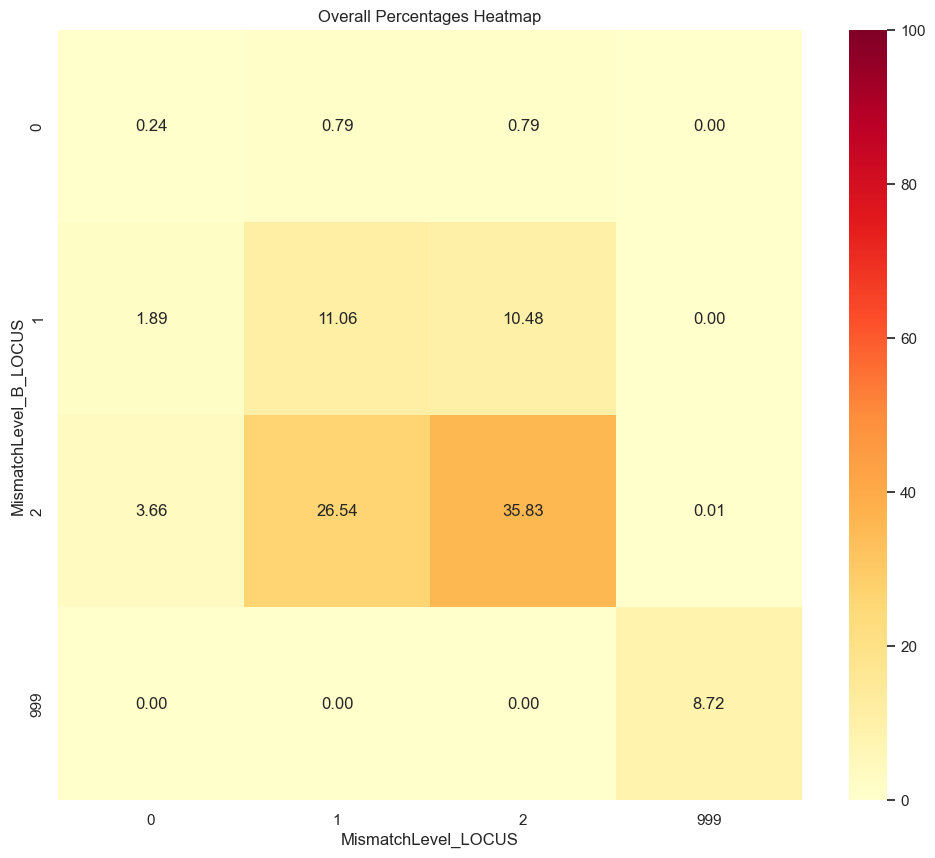

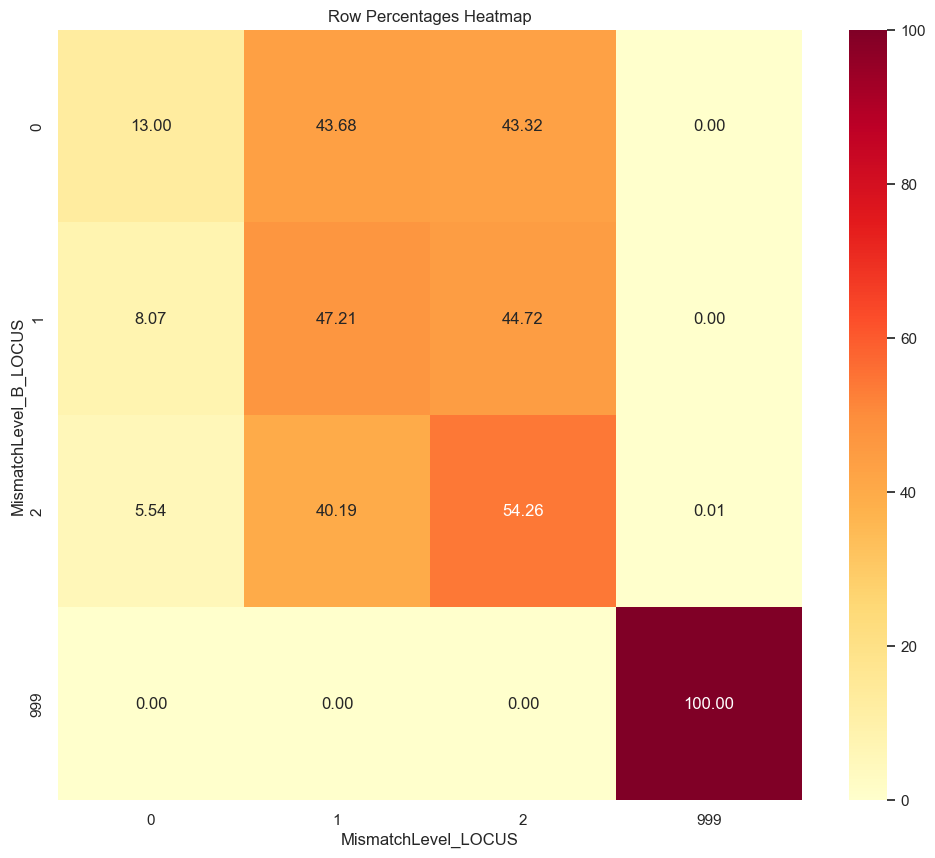

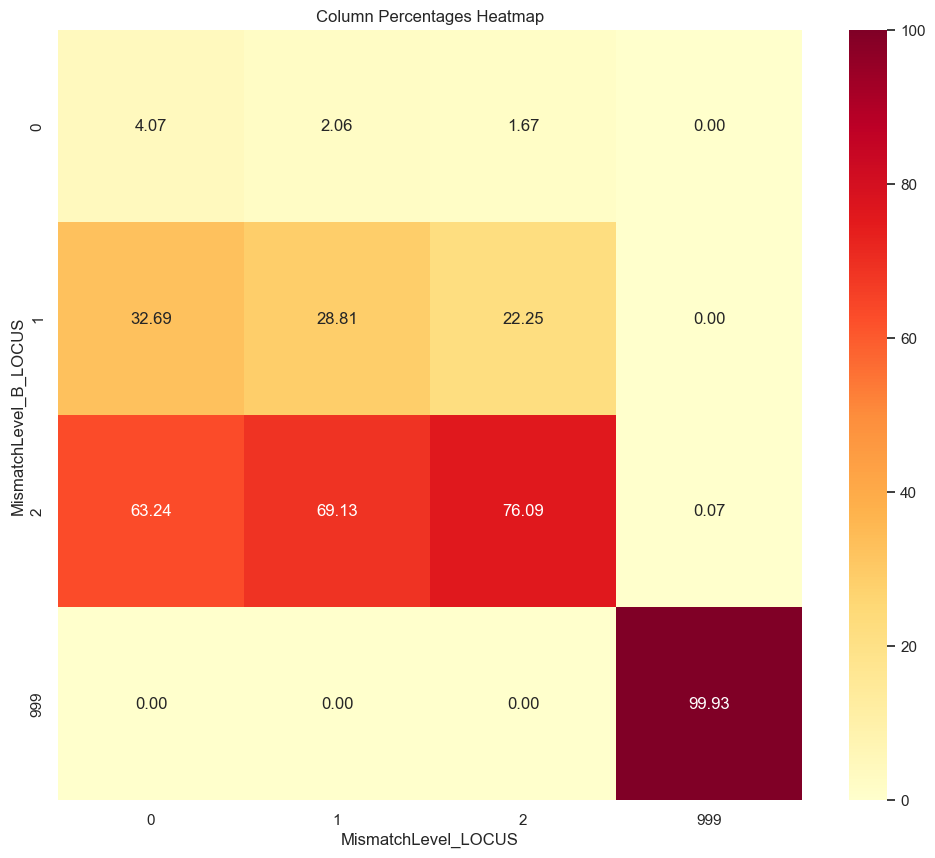

In [37]:
# Create the DataFrame
data = {
    '0': [36, 289, 559, 0],
    '1': [121, 1690, 4056, 0],
    '2': [120, 1601, 5476, 0],
    '999': [0, 0, 1, 1333]
}
df_data = pd.DataFrame(data, index=['0', '1', '2', '999'])
df_data.index.name = 'MismatchLevel_B_LOCUS'
df_data.columns.name = 'MismatchLevel_LOCUS'

# 1. Overall percentages
total = df_data.values.sum()
df_overall_pct = df_data / total * 100

# 2. Row percentages (percentages within MismatchLevel_B_LOCUS)
df_row_pct = df_data.div(df_data.sum(axis=1), axis=0) * 100

# 3. Column percentages (percentages within MismatchLevel_LOCUS)
df_col_pct = df_data.div(df_data.sum(axis=0), axis=1) * 100

# Function to display percentages with custom formatting
def display_percentages(df_pct, title):
    print(f"\n{title}")
    print(df_pct.round(2).map(lambda x: f"{x:.2f}%" if x != 0 else "0%"))

# Display the percentages
display_percentages(df_overall_pct, "Overall Percentages:")
display_percentages(df_row_pct, "Row Percentages (within MismatchLevel_B_LOCUS):")
display_percentages(df_col_pct, "Column Percentages (within MismatchLevel_LOCUS):")

# Visualize the percentages
def plot_heatmap(df_pct, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_pct, annot=True, fmt='.2f', cmap='YlOrRd', vmin=0, vmax=100)
    plt.title(title)
    plt.show()

plot_heatmap(df_overall_pct, "Overall Percentages Heatmap")
plot_heatmap(df_row_pct, "Row Percentages Heatmap")
plot_heatmap(df_col_pct, "Column Percentages Heatmap")

Chi-square statistic: 15409.69626516143
p-value: 0.0


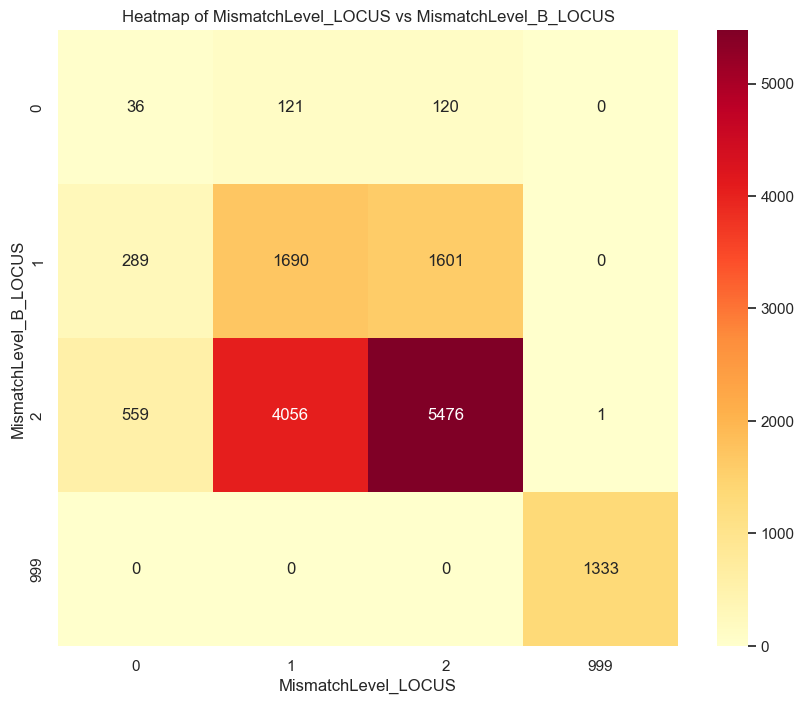

In [37]:


# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(df_data)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Heatmap of MismatchLevel_LOCUS vs MismatchLevel_B_LOCUS')
plt.show()

In [38]:
contingencyTable

MismatchLevel_LOCUS,0,1,2,999
MismatchLevel_B_LOCUS,,,,
0,36,121,120,0
1,289,1690,1601,0
2,559,4056,5476,1
999,0,0,0,1333


#### Feature Engineering

### Remove all NaNs (Preliminary Analysis)

In [23]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# seed
seed = 1776

In [24]:
df.shape

(15282, 318)

In [25]:
# remove feature used to engineer new features
removeCol = df_remove.colRemove.values

# remove features
df = removeColumn(df, removeCol)

Initial Data File Shape: (15282, 318)
After Data File Shape: (15282, 203)


In [26]:
# remove all NaNs
df = df.dropna()
print(f" Total of {df.shape[0]:,} Row(s) with {df.shape[1]:,} Column(s)")

 Total of 8,713 Row(s) with 203 Column(s)


In [27]:
# display datatypes
boolCol, categoryCol, objectCol, numberCol = datatypeDF(df, False)

# combine all feature names
allCol = boolCol + categoryCol + objectCol + numberCol
print(f"\nTotal Number of Features:  {len(allCol)}")

Total Data feature count:  203

Boolean feature count: 38
Category feature count: 101
Numeric feature count: 61
Object feature count: 3

Total feature count:  203

Total Number of Features:  203


In [28]:
# separate ordinal & nominal
catColO, missingColO = intersectionCol(df_dict, allCol, 'Ordinal', False)
catColN, missingColN = intersectionCol(df_dict, allCol, 'Nominal', False)
numCol,  missingColNum  = intersectionCol(df_dict, allCol, 'Continuous', False)

Features from Data Dictionary:  31
Intersection Features:  9
Missing Count 22
Features from Data Dictionary:  153
Intersection Features:  91
Missing Count 62
Features from Data Dictionary:  71
Intersection Features:  38
Missing Count 33


In [29]:
# combine list
missing = missingColO + missingColN + missingColNum
# # display
# df_dict.loc[:, ['featureName', 'dataType', 'COMMENT', 'Information']][df_dict.featureName.isin(missing)]
# boolCol, categoryCol, objectCol, numberCol 

In [30]:
# correlation pearson
corrCols(df[numberCol], threshold=0.8, method='pearson', flag=False)

Correlation between GraftLifeSpanDay and TransplantSurvivalDay: 0.999
Correlation between WeightKg_difference and BMI_difference: 0.888
Correlation between WeightKg_DON and BMI_DON: 0.878
Correlation between WeightKg_CAN and BMI_CAN: 0.843
Correlation between Hemodynamics_PA_DIA_difference and Hemodynamics_PA_MN_difference: 0.848
Correlation between Hemodynamics_PA_MN_difference and Hemodynamics_SYS_difference: 0.890


In [31]:
print(boolCol)

['Gender_difference', 'Citizenship_difference', 'ResidencyState_difference', 'TransplantState_difference', 'LifeSupport_ECMO_difference', 'LifeSupport_IABP_difference', 'IntropesIV_difference', 'LifeSupport_PGE_difference', 'LifeSupport_OTHER_difference', 'VentricularDeviceType_difference', 'VentricularDeviceBrand_difference', 'FunctionalStatus_difference', 'FunctionalStatus_difference_DON', 'PrimaryPayment_difference', 'Dialysis_difference', 'IntropesVasodilators_CO_difference', 'IntropesVasodilators_DIA_difference', 'IntropesVasodilators_MN_difference', 'IntropesVasodilators_PCW_difference', 'IntropesVasodilators_SYS_difference', 'Cigarette_difference', 'PriorCardiacSurgery_difference', 'PriorCardiacSurgeryType_difference', 'LifeSupport_difference', 'Status_difference', 'Ethnicity_difference', 'Ventilator_difference', 'WorkForIncome_difference', 'AntigenBW_difference', 'AntigenC_difference', 'AntigenDR5_12_difference', 'AntigenDR5_13_difference', 'AntigenDR5_12_22_difference', 'Antig

In [32]:
print(catColO)

['FollowupNumber', 'PrimaryDiagnosisCode_CAN', 'MismatchLevel_DR_LOCUS', 'PreTransplantMedicalCondition', 'BloodGroupMatchLevel', 'MismatchLevel_LOCUS', 'EducationLevel_CAN', 'MismatchLevel_B_LOCUS', 'MismatchLevel_HLA']


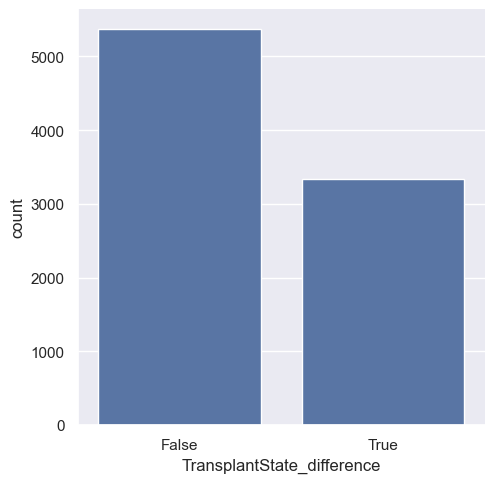

In [33]:
# plot using catplot (works well with boolean data)
sns.catplot(data=df, x="TransplantState_difference", kind="count")
plt.show()

### Test of Independence for Categorical Variables
- Null Hypothesis (H0): The two variables are not related.
- Alternative Hypothesis (H1): The two variables are related.
- A low p-value (typically < 0.05) indicates a significant relationship between the variables.
- This is the Chi-Square test statistic. It measures the discrepancy between the observed and expected frequencies under the assumption that the variables are independent.
    - A larger `chi2` value indicates a greater difference between observed and expected counts, suggesting that the variables are more likely to be associated.
    - A small p_value (typically < 0.05) suggests that you can reject the null hypothesis and conclude that there is a significant association between the two variables.

#### Cramer's V values can be interpreted as:
- Cramer's V is a measure of association between two nominal (categorical) variables, based on the Chi-Square statistic and varies from `0` (corresponding to no association between the variables) to `1` (complete association) and can reach 1 only when each variable is completely determined by the other.
    - 0.00 to 0.10: Negligible association
    - 0.10 to 0.30: Weak association
    - 0.30 to 0.50: Moderate association
    - 0.50 to 0.70: Strong association
    - 0.70 to 1.00: Very strong association

In [35]:
# # run test for ordinal
# df_test= pairColsMultiIndependenceCat(df_removeNan, catColO + catColN)
# df_test.head(15)

In [ ]:
includeCol = df_removeNan.columns[df_removeNan.columns.str.contains(r'(?i)difference')].values
includeCol.shape

### Examine NaNs

In [ ]:
# NaN counts
NaNDf = percentageNull(df)
# dispaly
NaNDf.head(15)

In [ ]:
# initialize
col = ['OtherDrugUse_DON', 'RejectionTreatmentWithinOneYear']
# display
addtionalInfo(df, col)

In [ ]:
sns.countplot(df, x='OtherDrugUse_DON');

####  Note:
These results indicate a strong, positive, and statistically significant relationship between your variables, which is linear and monotonic.

In [ ]:
correlation(df, 'Peak_CPRA', 'Recent_CPRA')

In [ ]:
# initialize
col = ['Peak_CPRA', 'Recent_CPRA']
# display
addtionalInfo(df, col)

In [ ]:
# define str search
strSearch = 'CPRA'
# search
DefinitionSearch(df_dict, strSearch, flag=False)

In [ ]:
# value counts
df.OtherDrugUse_DON.value_counts(dropna=False)

In [ ]:
# define str search
strSearch = 'OtherDrugUse_DON|RejectionTreatmentWithinOneYear|CPRA'
# search
DefinitionSearch(df_dict, strSearch, flag=False)

In [ ]:
# initialize
col = ['Peak_CPRA', 'Recent_CPRA', 'OtherDrugUse_DON', 'RejectionTreatmentWithinOneYear']
# display
addtionalInfo(df, col)

In [ ]:
# remove
removeCol = ['RejectionTreatmentWithinOneYear']

In [ ]:
df_flat.head()

In [ ]:
df_flat[df_flat.SASAnalysisFormat.str.contains(r'(?i)CPRA')]

### Determine DataFrame Datatypes 

In [ ]:
df.dtypes.unique()

In [ ]:
# initialize variables for all the column name per each datatype
boolCol = df.select_dtypes(include=['bool']).columns.tolist()
categoryCol = df.select_dtypes(include=['category']).columns.tolist()
objectCol = df.select_dtypes(include=['object']).columns.tolist()
numberCol = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# display feature counts
print('Total Data feature count: ', df.shape[1])
print(f"\nBoolean feature count: {len(boolCol)}")
print(f"Category feature count: {len(categoryCol)}")
print(f"Numeric feature count: {len(numberCol)}")
print(f"Object feature count: {len(objectCol)}\n")
print('Total feature count: ' ,len(boolCol) + len(categoryCol) + len(objectCol) + len(numberCol))

In [ ]:
# feature names for all categorical variables
catCol = df_dict[['featureName', 'dataType']][df_dict.dataType.str.contains(r'Nominal|Ordinal')]
# array for categorical features
catCol = catCol.featureName.values
# display
catCol.shape

In [ ]:
# result for Testing of Independence for Catergorical Variables
df_result = pairColsMultiIndependenceCat(df, catCol)

# disply top 15
df_result.head(15)

#### Practical implications of Cramer's V: 1.0000:
- TransplantType completely determines HeartProcedureType and vice versa
- This suggests these variables might be encoding the same or highly related information
- It's possible one variable was derived from the other
#### Test of Independence for Catergorical Variables
- With such a low p-value, we strongly reject the null hypothesis of independence between the variables. 

In [ ]:
testIndependenceCat(df, 'Diabetes_DON', 'DiabetesHistory_DON', True)

The chi-square statistic of 30,564.00 with a p-value of 0.0000 indicates a statistically significant relationship between Diabetes_DON and DiabetesHistory_DON. The extremely low p-value (<< 0.05) suggests that the observed distribution is very unlikely to occur by chance.

In [ ]:
DefinitionSearch(df_dict, 'Diabetes_DON|DiabetesHistory_DON')

In [ ]:
testIndependenceCat(df, 'TransplantType', 'HeartProcedureType', True)

The chi-square statistic of 14,859.00 with a p-value of 0.0000 indicates a statistically significant relationship between TransplantType and HeartProcedureType. The extremely low p-value (<< 0.05) suggests that the observed distribution is very unlikely to occur by chance.

In [ ]:
DefinitionSearch(df_dict, 'TransplantType|HeartProcedureType')

In [ ]:
testIndependenceCat(df, 'CancerSite_DON', 'HistoryCancer_DON', True)

The chi-square statistic of 30,558.00 with a p-value of 0.0000 indicates a statistically significant relationship between CancerSite_DON and HistoryCancer_DON. The extremely low p-value (<< 0.05) suggests that the observed distribution is very unlikely to occur by chance.

In [ ]:
DefinitionSearch(df_dict, 'CancerSite_DON|HistoryCancer_DON')

In [ ]:
# 


### Impute Catergory Features

In [ ]:
# split dataset
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OrdinalEncoder
from sklearn.decomposition import PCA

# seed
seed = 1776

#### Encode Categorical Feature(s)

In [ ]:
df_cleaned.shape

In [ ]:
ordinalCol = df_dict.featureName[df_dict.Information.str.contains('Ordinal', na=False)].values

# remove unwanted values
unwanted = ['FunctionalStatus_CAN', 'InitialFunctionalStatus_DON','FunctionalStatus_DON']
ordinalCol = ordinalCol[~np.isin(ordinalCol, unwanted)]
ordinalCol

In [ ]:
df_cleaned[ordinalCol].dtypes

In [ ]:
df_cleaned['DiagnosisType'].value_counts()

In [ ]:
df_cleaned['DiagnosisType'].unique()

In [ ]:
df_cleaned['DiagnosisType'].cat.codes.unique()

In [ ]:
ordinal.shape

#### Scale Data

In [ ]:
scaleCol = df_dummies.select_dtypes(include=['int','float']).columns.values

# display
scaleCol